In [1]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import warnings
import math
from scipy.optimize import curve_fit
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

## Dataframe defining functions

In [2]:
def connectivityExtractor(name):
    file_path = 'FluidsInput/FluidInput_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    connectivity_raw = data_structure['connectivity'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    connectivity_data = connectivity_raw.squeeze()
    # Create a DataFrame from the connectivity data
    connectivity_df = pd.DataFrame(connectivity_data, columns=['Parent', 'Daughter1', 'Daughter2', 'Daughter3'])
    connectivity_df['Parent'] = connectivity_df['Parent']+1
    connectivity_df['Daughter1'] = connectivity_df['Daughter1']+1
    connectivity_df['Daughter2'] = connectivity_df['Daughter2']+1
    connectivity_df['Daughter3'] = connectivity_df['Daughter3']+1
    # Save the DataFrame to inspect it
    return connectivity_df

def lengthExtractor(name):
    file_path = 'FluidsInput/FluidInput_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    length_raw = data_structure['lengths'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    length_data = length_raw.squeeze()
    # Create a DataFrame from the connectivity data
    length_df = pd.DataFrame(length_data, columns=['Length'])
    # Save the DataFrame to inspect it
    return length_df

def radiusExtractor(name):
    file_path = 'FluidsInput/FluidInput_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    radius_raw = data_structure['rin'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    radius_data = radius_raw.squeeze()
    # Create a DataFrame from the connectivity data
    radius_df = pd.DataFrame(radius_data, columns=['Radius'])
    # Save the DataFrame to inspect it
    return radius_df

def radiusFinder(data):
    dv1r = np.empty((0,0))
    dv2r = np.empty((0,0))
    dv3r = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        dv1 = data.iloc[i][3]-1
        dv2 = data.iloc[i][4]-1
        dv3 = data.iloc[i][5]-1
        if dv1 == 0:
            dv1r = np.append(dv1r,np.nan)
            dv2r = np.append(dv2r,np.nan)
            dv3r = np.append(dv3r,np.nan)
            continue
        dv1r = np.append(dv1r,data.iloc[int(dv1)][2])
        dv2r = np.append(dv2r,data.iloc[int(dv2)][2])
        if dv3 == 0:
            dv3r = np.append(dv3r,np.nan)
            continue
        dv3r = np.append(dv3r,data.iloc[int(dv3)][2])
    data['DV1R'] = dv1r.tolist()
    data['DV2R'] = dv2r.tolist()
    data['DV3R'] = dv3r.tolist()
    data = data.loc[:,['Parent','Length','Radius','Daughter1','DV1R','Daughter2','DV2R','Daughter3','DV3R']]
    return data

def alphaBeta(data):
    alpha = np.empty((0,0))
    beta = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if not math.isnan(data.iloc[i][8]):
            alpha = np.append(alpha,np.nan)
            beta = np.append(beta,np.nan)
            continue
        dv1r = data.iloc[i][4]
        dv2r = data.iloc[i][6]
        pv = data.iloc[i][2]
        if math.isnan(dv1r):
            alpha = np.append(alpha,np.nan)
            beta = np.append(beta,np.nan)
            continue
        if dv1r>=dv2r:
            alpha_value = dv1r/pv
            beta_value = dv2r/pv
        else:
            alpha_value = dv2r/pv
            beta_value = dv1r/pv
        alpha = np.append(alpha,alpha_value)
        beta = np.append(beta,beta_value)
    data['Alpha'] = alpha.tolist()
    data['Beta'] = beta.tolist()
    return data

def lRR(data):
    lrr = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        length = data.iloc[i][1]
        radius = data.iloc[i][2]
        lrr_value = length/radius
        lrr = np.append(lrr,lrr_value)
    data['Length/Radius'] = lrr.tolist()
    return data

def dataExtractor(name):
    connectivity = connectivityExtractor(name)
    length = lengthExtractor(name)
    radius = radiusExtractor(name)
    combined = pd.concat([connectivity.iloc[:, :1], length, radius, connectivity.iloc[:, 1:]], axis=1)
    all = radiusFinder(combined)
    alphabetazed = alphaBeta(all)
    lengthradius = lRR(alphabetazed)
    return lengthradius

In [3]:
m3p4c = 'm3p4_060407'
control3p4 = dataExtractor(m3p4c)
m2p4c = 'm2p4_060407'
control2p4 = dataExtractor(m2p4c)
m1p4c = 'm1p4_060407'
control1p4 = dataExtractor(m1p4c)
m1p4h = 'm1p4_053007'
hyper1p4 = dataExtractor(m1p4h)
m2p4h = 'm2p4_053007'
hyper2p4 = dataExtractor(m2p4h)
m3p4h = 'm1p4_053107'
hyper3p4 = dataExtractor(m3p4h)

# Bin Graphs

In [4]:
def bintoplotAB(data):
    filtered = data[data['Radius'] < .4*data.iloc[0][2]]
    filtered = filtered.drop('DV3R',axis=1)
    filtered = filtered.dropna()
    labels = np.arange(20)
    filtered['binned'] = pd.qcut(filtered['Radius'], 20,labels = labels)
    a = filtered.groupby('binned')['Radius'].mean()
    b = filtered.groupby('binned')['Alpha'].mean()
    c = filtered.groupby('binned')['Beta'].mean()
    return a,b,c


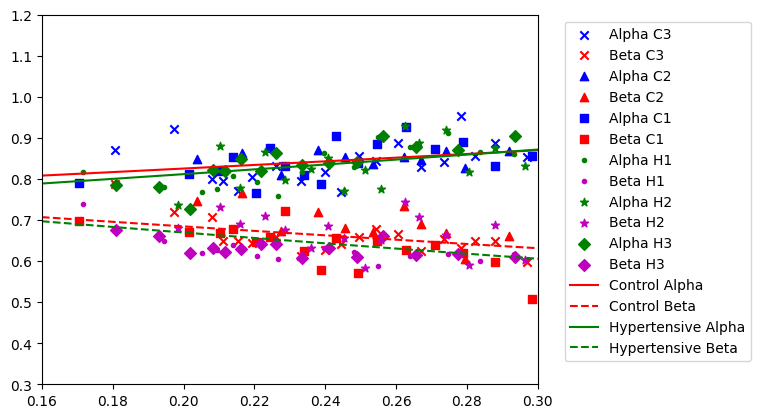

In [22]:
c3p4r,c3p4a,c3p4b = bintoplotAB(control3p4)
c2p4r,c2p4a,c2p4b = bintoplotAB(control2p4)
c1p4r,c1p4a,c1p4b = bintoplotAB(control1p4)
h1p4r,h1p4a,h1p4b = bintoplotAB(hyper1p4)
h2p4r,h2p4a,h2p4b = bintoplotAB(hyper2p4)
h3p4r,h3p4a,h3p4b = bintoplotAB(hyper3p4)

controla = np.concatenate((c1p4a,c2p4a,c3p4a),axis=0)
controlr = np.concatenate((c1p4r,c2p4r,c3p4r),axis=0)
controlb = np.concatenate((c1p4b,c2p4b,c3p4b),axis=0)
hypa = np.concatenate((h1p4a,h2p4a,h3p4a),axis=0)
hypb = np.concatenate((h1p4b,h2p4b,h3p4b),axis=0)
hypr = np.concatenate((h1p4r,h2p4r,h3p4r),axis=0)

def exponential(x, a, b):
    return a * np.exp(b * x)

paramsca, _ = curve_fit(exponential, controlr, controla)
paramscb, _ = curve_fit(exponential, controlr, controlb)
paramsha, _ = curve_fit(exponential, hypr, hypa)
paramshb, _ = curve_fit(exponential, hypr, hypb)

x_range = np.linspace(.16,.3, 100)

ca_fit = exponential(x_range, *paramsca)
cb_fit = exponential(x_range, *paramscb)
ha_fit = exponential(x_range, *paramsha)
hb_fit = exponential(x_range, *paramshb)

plt.scatter(c3p4r,c3p4a, c='b', marker='x', label='Alpha C3')
plt.scatter(c3p4r, c3p4b, c='r', marker='x', label='Beta C3')
plt.scatter(c2p4r,c2p4a, c='b', marker='^', label='Alpha C2')
plt.scatter(c2p4r, c2p4b, c='r', marker='^', label='Beta C2')
plt.scatter(c1p4r,c1p4a, c='b', marker='s', label='Alpha C1')
plt.scatter(c1p4r, c1p4b, c='r', marker='s', label='Beta C1')
plt.scatter(h1p4r,h1p4a, c='g', marker='.', label='Alpha H1')
plt.scatter(h1p4r, h1p4b, c='m', marker='.', label='Beta H1')
plt.scatter(h2p4r,h2p4a, c='g', marker='*', label='Alpha H2')
plt.scatter(h2p4r, h2p4b, c='m', marker='*', label='Beta H2')
plt.scatter(h3p4r,h3p4a, c='g', marker='D', label='Alpha H3')
plt.scatter(h3p4r, h3p4b, c='m', marker='D', label='Beta H3')
plt.plot(x_range, ca_fit, color='red', linestyle='-', label='Control Alpha')
plt.plot(x_range, cb_fit, color='red', linestyle='--', label='Control Beta')
plt.plot(x_range, ha_fit, color='green', linestyle='-', label='Hypertensive Alpha')
plt.plot(x_range, hb_fit, color='green', linestyle='--', label='Hypertensive Beta')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.xlim(.16, .3)
plt.ylim(.3, 1.2)
plt.show()

In [20]:
def boxtoplotLRR(data):
    filtered = data[data['Radius'] < .4*data.iloc[0][2]]
    labels = np.arange(20)
    filtered['binned'] = pd.qcut(filtered['Radius'], 20,labels = labels)
    a = filtered.groupby('binned')['Length/Radius'].mean()
    b = filtered.groupby('binned')['Radius'].mean()
    return a,b

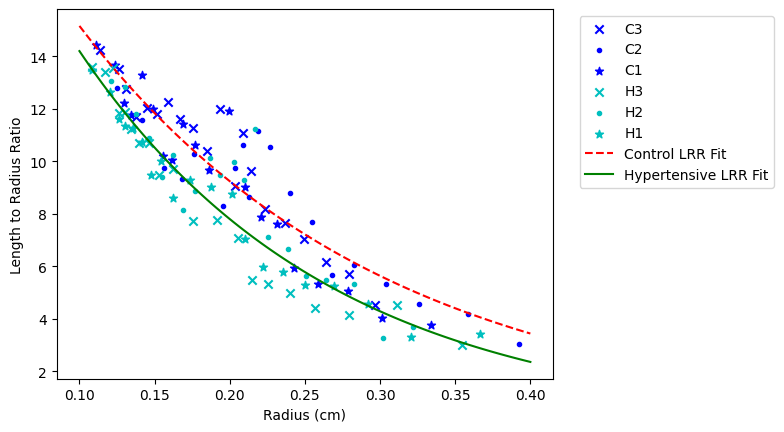

In [24]:
c3p4lrr,c3p4r = boxtoplotLRR(control3p4)
c2p4lrr,c2p4r = boxtoplotLRR(control2p4)
c1p4lrr,c1p4r = boxtoplotLRR(control1p4)
h3p4lrr,h3p4r = boxtoplotLRR(hyper3p4)
h2p4lrr,h2p4r = boxtoplotLRR(hyper2p4)
h1p4lrr,h1p4r = boxtoplotLRR(hyper1p4)

controllrr = np.concatenate((c1p4lrr,c2p4lrr,c3p4lrr),axis=0)
controlr = np.concatenate((c1p4r,c2p4r,c3p4r),axis=0)
hyplrr = np.concatenate((h1p4lrr,h2p4lrr,h3p4lrr),axis=0)
hypr = np.concatenate((h1p4r,h2p4r,h3p4r),axis=0)

def exponential(x, a, b):
    return a * np.exp(-b * x)

paramsclrr, _ = curve_fit(exponential, controlr, controllrr)
paramshlrr, _ = curve_fit(exponential, hypr, hyplrr)

x_range = np.linspace(.1,.4, 100)

clrr_fit = exponential(x_range, *paramsclrr)
hlrr_fit = exponential(x_range, *paramshlrr)

plt.scatter(c3p4r,c3p4lrr, c='b', marker='x', label='C3')
plt.scatter(c2p4r,c2p4lrr, c='b', marker='.', label='C2')
plt.scatter(c1p4r,c1p4lrr, c='b', marker='*', label='C1')
plt.scatter(h3p4r,h3p4lrr, c='c', marker='x', label='H3')
plt.scatter(h2p4r,h2p4lrr, c='c', marker='.', label='H2')
plt.scatter(h1p4r,h1p4lrr, c='c', marker='*', label='H1')
plt.plot(x_range, clrr_fit, color='red', linestyle='--', label='Control LRR Fit')
plt.plot(x_range, hlrr_fit, color='green', linestyle='-', label='Hypertensive LRR Fit')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.xlabel('Radius (cm)')
plt.ylabel('Length to Radius Ratio')
plt.show()

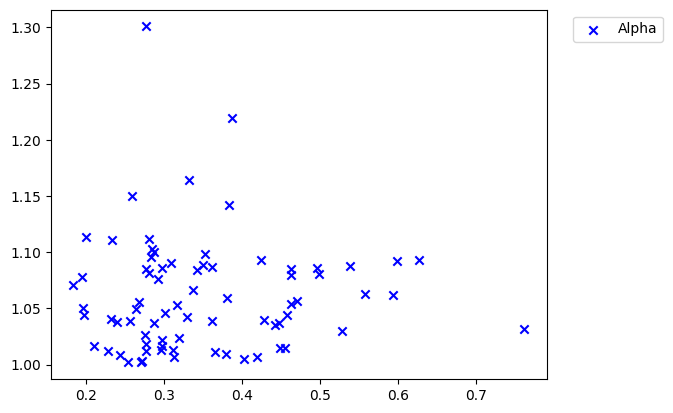

In [ ]:
fc3p4 = control3p4[control3p4['Alpha'] > 1]
fc3p4a = fc3p4['Alpha']
fc3p4r = fc3p4['Radius']
plt.scatter(fc3p4r,fc3p4a, c='b', marker='x', label='Alpha')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.show()

## Newton's Method

In [ ]:
def xiFinder(data):
    xi_values = np.empty((0,0))
    error_values = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        rp = data.iloc[i][2]
        rd1 = data.iloc[i][4]
        rd2 = data.iloc[i][6]
        rd3 = data.iloc[i][8]
        if not math.isnan(rd3):
            xi_values = np.append(xi_values,np.nan)
            error_values = np.append(error_values,np.nan)
            continue
        if math.isnan(rd1):
            xi_values = np.append(xi_values,np.nan)
            error_values = np.append(error_values,np.nan)
            continue
        #xi = -math.log(2)/math.log(data.iloc[i][9])
        xi = 1
        error = rp**xi - rd1**xi - rd2**xi
        while abs(error) > 1e-4:
            fun = rp**xi - rd1**xi - rd2**xi
            fun2 = (rp**xi)*math.log(rp) - (rd1**xi)*math.log(rd1) - (rd2**xi)*math.log(rd2)
            xi = xi - fun/fun2
            error = rp**xi - rd1**xi - rd2**xi
            #xi = max(1, min(6, xi))
            """if abs(rp**xi - rd1**xi - rd2**xi) < 1e-6:
                break"""
        if xi > 6:
            xi = 6
        error = rp**xi - rd1**xi - rd2**xi
        xi_values = np.append(xi_values,xi)
        error_values = np.append(error_values,error)
    data['Xi Newton'] = xi_values.tolist()
    data['Error Newton'] = error_values.tolist()
    return data


control3p4 = xiFinder(control3p4)
print(control3p4[['Parent', 'Alpha', 'Xi Newton','Error Newton']])

     Parent     Alpha  Xi Newton  Error Newton
0         1  1.031789   6.000000 -1.341991e-01
1         2       NaN        NaN           NaN
2         3       NaN        NaN           NaN
3         4       NaN        NaN           NaN
4         5       NaN        NaN           NaN
5         6       NaN        NaN           NaN
6         7       NaN        NaN           NaN
7         8       NaN        NaN           NaN
8         9       NaN        NaN           NaN
9        10       NaN        NaN           NaN
10       11       NaN        NaN           NaN
11       12       NaN        NaN           NaN
12       13       NaN        NaN           NaN
13       14       NaN        NaN           NaN
14       15       NaN        NaN           NaN
15       16       NaN        NaN           NaN
16       17       NaN        NaN           NaN
17       18       NaN        NaN           NaN
18       19       NaN        NaN           NaN
19       20       NaN        NaN           NaN
20       21  

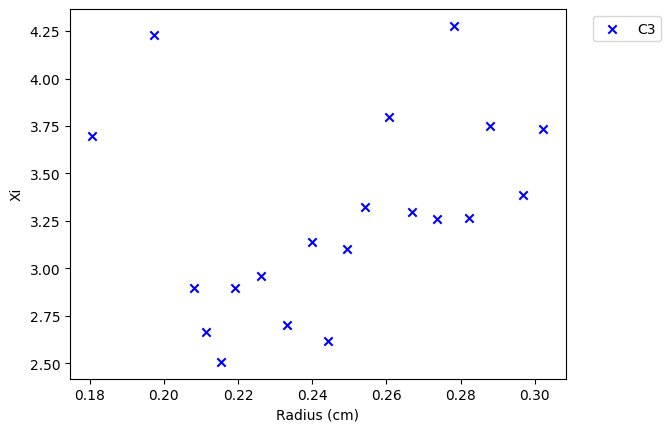

In [ ]:
filtered = control3p4[control3p4['Radius'] < .4*control3p4.iloc[0][2]]
filtered = filtered[['Radius', 'Xi Newton']]
filtered = filtered.dropna()
labels = np.arange(20)
filtered['binned'] = pd.qcut(filtered['Radius'], 20,labels = labels)
a = filtered.groupby('binned')['Xi Newton'].mean()
b = filtered.groupby('binned')['Radius'].mean()
plt.scatter(b,a, c='b', marker='x', label='C3')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.xlabel('Radius (cm)')
plt.ylabel('Xi')
plt.show()